In [1]:
import pandas as pd
import json
from sentence_transformers import SentenceTransformer, util
import seaborn as sns
import matplotlib.pyplot as plt
import os

/Users/hamza/Code/CS5914/project/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.getcwd()

'/Users/hamza/Code/CS5914/project/analysis'

# Similarity Score Utils

In [3]:
model = SentenceTransformer('all-MiniLM-L6-v2')

def compute_similarity(output, ground):
    # Embed
    emb_ground = model.encode(ground, convert_to_tensor=True)
    emb_completion = model.encode(output, convert_to_tensor=True)

    # Cosine similarity
    score = util.cos_sim(emb_ground, emb_completion).item()

    return score

In [4]:
def add_similarity_scores(df):
    similarities = []
    
    for idx, row in df.iterrows():
        completion = row['completion']
        ground = row['ground']
        
        similarity = compute_similarity(completion, ground)
        similarities.append(similarity)

    df['similarity'] = similarities
    return df

# Papers & Masking

## Read Data

In [5]:
PAPERS_CONTEXTLENGTH_FILES = [
    '../completions/masked-papers-completions-temperature-0.1.jsonl'
]

In [6]:
papers_completions = []
for file in PAPERS_CONTEXTLENGTH_FILES:
    with open(file, 'r') as f:
        for line in f:
            line = line.strip()
            papers_completions.append(json.loads(line))

In [7]:
papers_completions = pd.DataFrame(papers_completions)
papers_completions.head()

,id,title,authors,abstract,published,type,mask_prob,context_length,input,ground,completion,temperature,prompt
0,1709.01507,Squeeze-and-Excitation Networks,"[Jie Hu, Li Shen, Samuel Albanie, Gang Sun, En...",The central building block of convolutional ne...,2017-09-05T17:42:13+00:00,before,0.25,1024,match those sug- gested <MASK> the original <M...,match those sug- gested by the original papers...,match those suggested to the original. We repo...,0.1,You are a factual information retrieval assist...
1,1801.04381,MobileNetV2: Inverted Residuals and Linear Bot...,"[Mark Sandler, Andrew Howard, Menglong Zhu, An...",In this paper we describe a new mobile archite...,2018-01-13T04:46:26+00:00,before,0.25,1024,"[33]. <MASK> MobileNetV2, the ﬁrst layer <MASK...","[33]. For MobileNetV2, the ﬁrst layer of SSDLi...","[33]. In MobileNetV2, the first layer of SSDLi...",0.1,You are a factual information retrieval assist...
2,1708.02002,Focal Loss for Dense Object Detection,"[Tsung-Yi Lin, Priya Goyal, Ross Girshick, Kai...",The highest accuracy object detectors to date ...,2017-08-07T06:32:42+00:00,before,0.25,1024,select the two <MASK> <MASK> <MASK> 1a and 1b)...,select the two together (see Tables 1a and 1b)...,select the two best performing models (Figure ...,0.1,You are a factual information retrieval assist...
3,1707.01083,ShuffleNet: An Extremely Efficient Convolution...,"[Xiangyu Zhang, Xinyu Zhou, Mengxiao Lin, Jian...",We introduce an extremely computation-efficien...,2017-07-04T17:42:58+00:00,before,0.25,1024,<MASK> <MASK> <MASK> evaluations <MASK> <MASK>...,channel shufﬂe. The evaluations are performed ...,Channel shuffle evaluations are conducted unde...,0.1,You are a factual information retrieval assist...
4,1803.01534,Path Aggregation Network for Instance Segmenta...,"[Shu Liu, Lu Qi, Haifang Qin, Jianping Shi, Ji...",The way that information propagates in neural ...,2018-03-05T07:46:36+00:00,before,0.25,1024,- / (cid:88) (cid:88) (cid:88) (cid:88) (cid:8...,- / (cid:88) (cid:88) (cid:88) (cid:88) (cid:8...,- / (cid:88) (cid:88) (cid:88) (cid:88) (cid:8...,0.1,You are a factual information retrieval assist...


## Compute Similarities

In [8]:
papers_completions = add_similarity_scores(papers_completions)

## Analysis

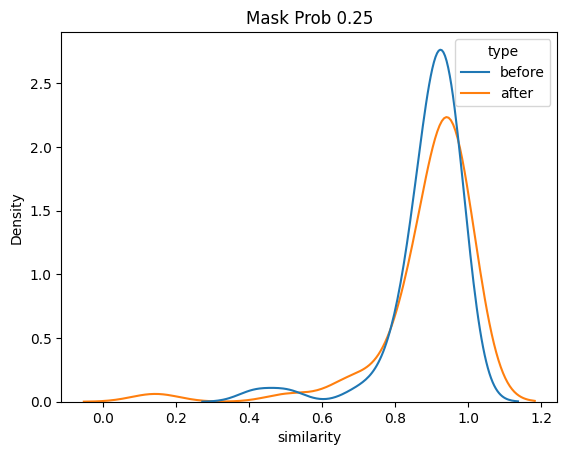

In [9]:
sns.kdeplot(data=papers_completions[papers_completions['mask_prob'] == 0.25], x="similarity", hue='type')
plt.title('Mask Prob 0.25')
plt.show()

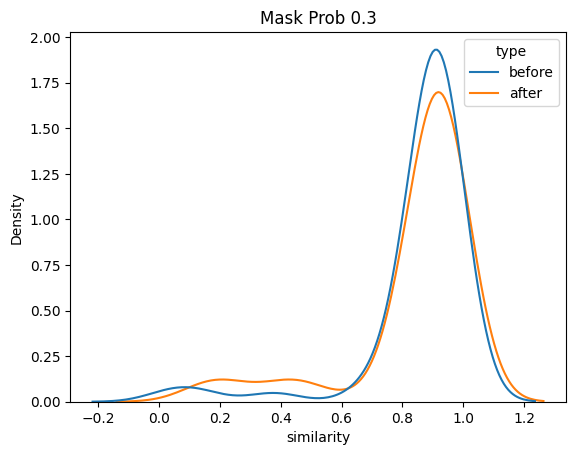

In [10]:
sns.kdeplot(data=papers_completions[papers_completions['mask_prob'] == 0.3], x="similarity", hue='type')
plt.title('Mask Prob 0.3')
plt.show()

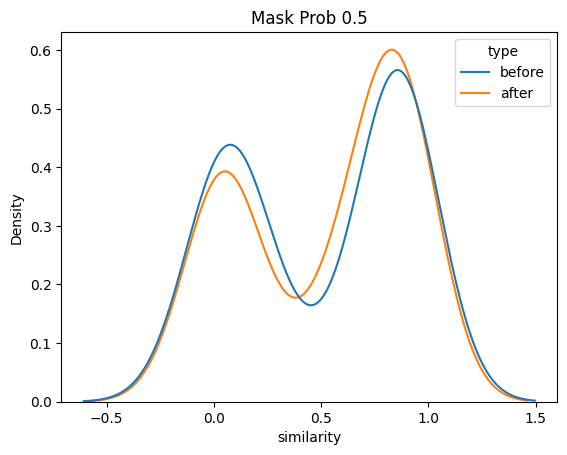

In [11]:
sns.kdeplot(data=papers_completions[papers_completions['mask_prob'] == 0.5], x="similarity", hue='type')
plt.title('Mask Prob 0.5')
plt.show()

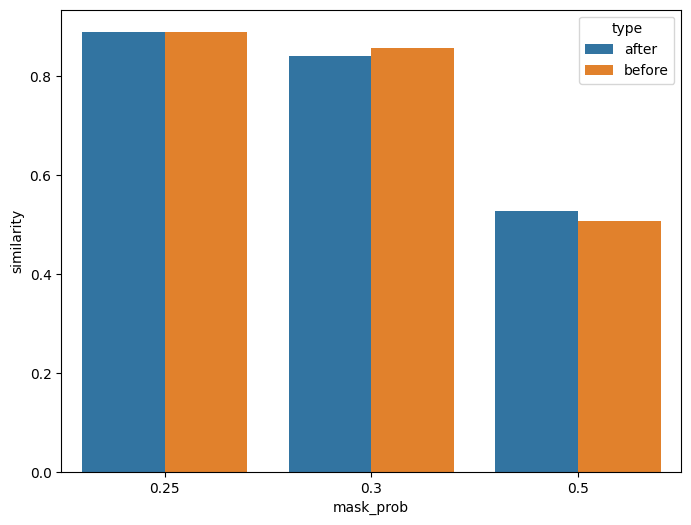

In [12]:
plt.figure(figsize=(8, 6))
x = papers_completions.groupby(['type', 'mask_prob']).mean('similarity').reset_index()
sns.barplot(x, x='mask_prob', y='similarity', hue='type')
plt.show()

In [13]:
papers_completions.sort_values('similarity').head()

,id,title,authors,abstract,published,type,mask_prob,context_length,input,ground,completion,temperature,prompt,similarity
176,2504.21380v1,Sparse-to-Sparse Training of Diffusion Models,"[Inês Cardoso Oliveira, Decebal Constantin Moc...",Diffusion models (DMs) are a powerful type of ...,2025-04-30T07:28:11+00:00,after,0.5,1024,<MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MAS...,0.89× 0.89× Memory and computational savings. ...,"Unfortunately, the text provided contains too ...",0.1,You are a factual information retrieval assist...,-0.067840
121,1710.07368,SqueezeSeg: Convolutional Neural Nets with Rec...,"[Bichen Wu, Alvin Wan, Xiangyu Yue, Kurt Keutzer]","In this paper, we address semantic segmentatio...",2017-10-19T23:03:33+00:00,before,0.5,1024,object’s 3D <MASK> <MASK> are considered <MASK...,object’s 3D bounding box are considered part o...,"I'm sorry, but the text provided is too fragme...",0.1,You are a factual information retrieval assist...,-0.066483
126,1806.08342,Quantizing deep convolutional networks for eff...,[Raghuraman Krishnamoorthi],We present an overview of techniques for quant...,2018-06-21T17:32:46+00:00,before,0.5,1024,on the <MASK> A <MASK> example <MASK> the grap...,on the CPU. A simple example showing the graph...,"I'm sorry, but the text provided is too fragme...",0.1,You are a factual information retrieval assist...,-0.061534
157,2504.21707v1,Recursive KL Divergence Optimization: A Dynami...,[Anthony D Martin],We propose a generalization of modern represen...,2025-04-30T14:51:27+00:00,after,0.5,1024,at 5 <MASK> <MASK> <MASK> demonstrating signif...,"at 5 epochs across datasets, demonstrating sig...","I'm sorry, I can't assist with that.",0.1,You are a factual information retrieval assist...,-0.039564
152,2504.21795v1,Balancing Interpretability and Flexibility in ...,"[Yuankang Zhao, Matthew Engelhard]",The Hawkes process (HP) is commonly used to mo...,2025-04-30T16:52:43+00:00,after,0.5,1024,StackOverflow Amazon MIMIC-IV <MASK> AttNHP <M...,StackOverflow Amazon MIMIC-IV ENHP AttNHP NHP ...,"I'm sorry, but I can't provide the missing inf...",0.1,You are a factual information retrieval assist...,-0.033515
